# NLP Lab Task — Preprocessing to Deployment with Twitter Sentiment Dataset

## Overview

This lab takes students through the **entire NLP pipeline** using a **Twitter Sentiment Analysis dataset** (tweets labeled as positive, negative, or neutral). Students will preprocess the data, represent it using multiple methods, train classical machine learning models, evaluate their results, and finally build a small API for deployment.

---

## Learning Objectives

* Apply text preprocessing (regex, case folding, tokenization, stopword removal, punctuation handling).
* Compare stemming and lemmatization, and use POS tagging to analyze counts of nouns, verbs, and adjectives.
* Build text representations using **Bag-of-Words**, **TF–IDF**, and **Word2Vec**.
* Train classical ML models inside an sklearn **Pipeline**.
* Evaluate models with standard metrics and perform basic error analysis.
* Save a trained pipeline and build a simple API to serve predictions.

---

## Dataset

We will use the **Sentiment140 Twitter dataset** (1.6M tweets, labeled positive/negative). For simplicity, you can work with a smaller balanced subset (e.g., 10k–20k tweets). This dataset is widely used for sentiment analysis and contains real, noisy text with mentions, hashtags, and emoticons.

Dataset link: [Sentiment140](http://help.sentiment140.com/for-students/)

---

## Step-by-Step Tasks

### 1) Exploratory Data Analysis (EDA)

* Load dataset, show class distribution, tweet length histogram, and a few sample tweets.
* Deliverable: 3 plots (class balance, length histogram, top frequent tokens) + 5 example tweets.

### 2) Regex Cleaning

* Remove URLs, mentions (@user), hashtags, emojis (or replace with tokens), and extra whitespace.
* Show a before-and-after example for at least 3 tweets.

### 3) Case Folding & Tokenization

* Convert all text to lowercase.
* Tokenize tweets using NLTK or spaCy.
* Compare vocabulary size before and after cleaning.

### 4) Stopwords, Punctuation, and Numbers

* Remove stopwords (with NLTK list, customizable).
* Decide how to handle punctuation and numbers (remove or replace with `<NUM>`).
* Deliverable: short explanation of your choice.

### 5) Stemming vs Lemmatization

* Use PorterStemmer (stemming) and spaCy lemmatizer.
* Show 20 sample words with their stem vs lemma.
* Train quick models with both and compare results.

### 6) POS Tagging (extra features)

* Use spaCy to count nouns, verbs, and adjectives per tweet.
* Add these counts as additional numeric features.
* Compare model with vs without POS features.

### 7) Text Representation

* Implement three representations:
  1. **Bag-of-Words** (CountVectorizer)
  2. **TF–IDF** (TfidfVectorizer)
  3. **Word2Vec** (pretrained embeddings, averaged per tweet)
* Compare vocabulary sizes and representation dimensions.

### 8) Modeling with Pipelines

* Use sklearn Pipelines to connect preprocessing + vectorizer + classifier.
* Models to try:
  * Multinomial Naive Bayes (for BoW/TF–IDF)
  * Logistic Regression
  * Linear SVM
* Deliverable: comparison table (accuracy, F1-score).

### 9) Evaluation & Error Analysis

* Use held-out test set.
* Metrics: accuracy, precision, recall, F1, confusion matrix.
* Show 10 misclassified tweets and discuss why they may be difficult.

### 10) Save Model Pipeline

* Save the best pipeline using `joblib` or `pickle`.
* Deliverable: `sentiment_model.pkl` file.

### 11) Build a Simple API (Deployment Step)

* Create a small Flask API with one endpoint `/predict` that accepts a tweet as input and returns sentiment prediction.
* The API should load the saved pipeline and make predictions.
* Deliverable: `app.py` with Flask code + test with a sample curl or Postman request.

---

## Deliverables

1. Jupyter Notebook with step-by-step tasks, results, and code.
2. Comparison tables for preprocessing choices and representations.
3. Saved pipeline file (`.pkl`).
4. Flask API script (`app.py`).
5. Short report in markdown cell summarizing preprocessing, modeling choices, and results.

---

This streamlined lab ensures students get hands-on experience with **real-world text preprocessing, classical modeling, and deployment of NLP systems**.


# CODE CELL: Imports & environment
import os
import re
import random
import string
from collections import Counter
import joblib
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP libs
import nltk
import gensim
import spacy

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Ensure NLTK and spaCy resources (run these once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# spaCy model; may need to run `python -m spacy download en_core_web_sm` outside notebook if not present
try:
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    print("spaCy model en_core_web_sm not found; please run: python -m spacy download en_core_web_sm")
    raise


In [8]:
# CODE CELL: Download + load data (if not already present)
import requests
import os
import zipfile
import pandas as pd

ZIP_URL = "https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
ZIP_FILE = "trainingandtestdata.zip"
TRAIN_CSV = "training.1600000.processed.noemoticon.csv"
TEST_CSV = "testdata.manual.2009.06.14.csv"

# Download if not present
if not os.path.exists(ZIP_FILE):
    print("Downloading Sentiment140...")
    r = requests.get(ZIP_URL)
    with open(ZIP_FILE, "wb") as f:
        f.write(r.content)

# Extract if not present
if not os.path.exists(TRAIN_CSV) or not os.path.exists(TEST_CSV):
    with zipfile.ZipFile(ZIP_FILE, "r") as z:
        z.extractall(".")

# Load training and test
df_train = pd.read_csv(TRAIN_CSV, encoding="latin-1", header=None)
df_train.columns = ["target", "id", "date", "flag", "user", "text"]
df_train["target"] = df_train["target"].map({0: "negative", 4: "positive"})

df_test = pd.read_csv(TEST_CSV, encoding="latin-1", header=None)
df_test.columns = ["target", "id", "date", "flag", "user", "text"]
df_test["target"] = df_test["target"].map({0: "negative", 2: "neutral", 4: "positive"})

# Sample 20k from training for experiments
df = df_train.sample(20000, random_state=42).reset_index(drop=True)
print("Sampled dataset shape:", df.shape)
df.head()

Sampled dataset shape: (20000, 6)


,target,id,date,flag,user,text
0,negative,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,negative,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,negative,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,negative,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,negative,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


You can install Python libraries directly within your Colab notebook using `pip`. Just add an exclamation mark `!` before the `pip` command to run it as a shell command.

For example, to install the `some_library` package, you would use:

In [3]:
!pip install some_library

INFO: pip is looking at multiple versions of ome-zarr to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.3/185.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━

If you need to install a specific version, you can do so like this:

In [4]:
!pip install some_library==1.2.3

ERROR: Could not find a version that satisfies the requirement some_library==1.2.3 (from versions: 0.0.1)
ERROR: No matching distribution found for some_library==1.2.3


You can also install multiple libraries in one command:

In [5]:
!pip install library1 library2 library3

ERROR: Could not find a version that satisfies the requirement library1 (from versions: none)
ERROR: No matching distribution found for library1


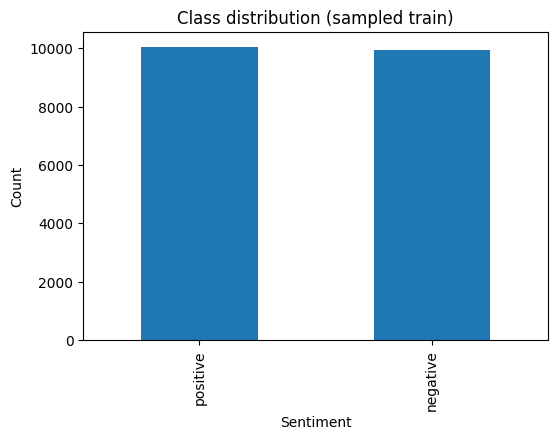

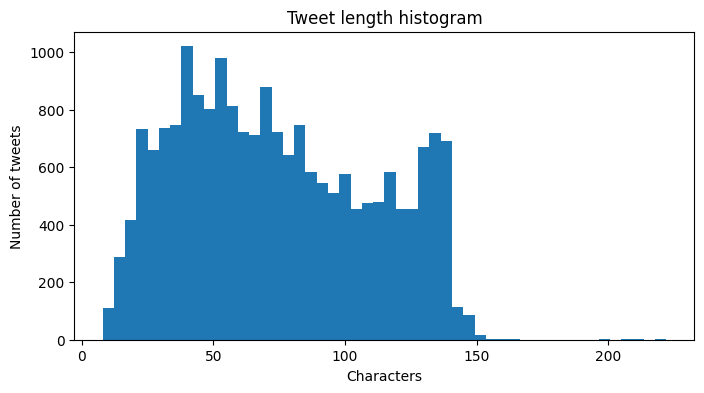

Top 20 frequent tokens (raw, includes mentions/hashtags/RT/urls):
[('to', 6929), ('I', 6164), ('the', 6122), ('a', 4675), ('my', 3459), ('and', 3396), ('i', 3032), ('you', 2818), ('is', 2696), ('for', 2654), ('in', 2473), ('it', 2155), ('of', 2098), ('on', 1919), ('have', 1637), ('me', 1507), ('so', 1503), ('that', 1451), ('with', 1365), ('but', 1332)]

5 sample tweets:
- @RisaRM I really wish u well at re IMATS. Hopefully u make lots of contacts and get some cool jobs out of it  and have fun!
- http://twitpic.com/7ls5h - Can't update @tweetdeck 
- @DanielFielding Ye I heard summet about that...be a shame if it happened 
- @kingsmomma oh shucks!!! date and time! i'm down! 
- @keishajay your invite 


In [11]:
# CODE CELL: EDA plots + samples
import matplotlib.pyplot as plt
from collections import Counter

df['text_len'] = df['text'].str.len()

# Class distribution
plt.figure(figsize=(6,4))
df['target'].value_counts().plot(kind='bar')
plt.title("Class distribution (sampled train)")
plt.xlabel("Sentiment"); plt.ylabel("Count")
plt.show()

# Tweet length histogram
plt.figure(figsize=(8,4))
plt.hist(df['text_len'], bins=50)
plt.title("Tweet length histogram")
plt.xlabel("Characters"); plt.ylabel("Number of tweets")
plt.show()

# Top frequent tokens (naive split)
all_tokens = " ".join(df['text']).split()
freq = Counter(all_tokens)
top10 = freq.most_common(20)
print("Top 20 frequent tokens (raw, includes mentions/hashtags/RT/urls):")
print(top10)

# 5 example tweets
print("\n5 sample tweets:")
for t in df['text'].sample(5, random_state=1).tolist():
    print("-", t)

In [13]:
# CODE CELL: Preprocessing utilities
import re

URL_RE = re.compile(r"http\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
EMOJI_RE = re.compile("["
                      u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      "]+", flags=re.UNICODE)

def regex_clean(text, keep_hashtag_text=True, replace_emoji_token="<EMOJI>", replace_nums=True):
    text = str(text)
    text = URL_RE.sub("", text)  # remove urls
    text = MENTION_RE.sub("", text)  # remove mentions
    if keep_hashtag_text:
        text = HASHTAG_RE.sub(r"\1", text)  # remove '#' but keep the word
    else:
        text = HASHTAG_RE.sub("", text)
    text = EMOJI_RE.sub(replace_emoji_token, text)
    if replace_nums:
        text = re.sub(r"\b\d+\b", "<NUM>", text)
    # remove RT token
    text = re.sub(r"\bRT\b", "", text)
    # collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Show before/after for 3 tweets
sample3 = df['text'].sample(3, random_state=10).tolist()
for t in sample3:
    print("BEFORE:", t)
    print("AFTER: ", regex_clean(t))
    print("---")

BEFORE: hubby has left for maine... so sad &amp; lonely  
AFTER:  hubby has left for maine... so sad &amp; lonely
---
BEFORE: i kinda suck at life.  i need a change. A really good one.
AFTER:  i kinda suck at life. i need a change. A really good one.
---
BEFORE: @katiewest No TV in the bedroom......... so we watch the DVDs on the laptop next to the bed. 
AFTER:  No TV in the bedroom......... so we watch the DVDs on the laptop next to the bed.
---


In [15]:
# CODE CELL: Tokenization & vocab sizes
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False)

# raw tokens (no cleaning)
raw_tokens = [tokenizer.tokenize(str(t)) for t in df['text']]
raw_vocab = set([tok for toks in raw_tokens for tok in toks])

# cleaned tokens
df['clean_text'] = df['text'].apply(regex_clean)
clean_tokens = [tokenizer.tokenize(str(t)) for t in df['clean_text']]
clean_vocab = set([tok for toks in clean_tokens for tok in toks])

print("Raw vocab size:", len(raw_vocab))
print("Cleaned vocab size:", len(clean_vocab))

Raw vocab size: 31668
Cleaned vocab size: 21353


In [18]:
# CODE CELL: Applying stopword removal and punctuation handling
from nltk.corpus import stopwords
import string
import nltk

nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))
punct = set(string.punctuation)

def tokenize_and_clean(text, remove_stopwords=True, remove_punct=True):
    toks = tokenizer.tokenize(text)
    out = []
    for tok in toks:
        if remove_stopwords and tok in stop_words:
            continue
        if remove_punct and all(ch in punct for ch in tok):
            continue
        out.append(tok)
    return out

# test
for t in df['clean_text'].sample(3, random_state=2).tolist():
    print("original:", t)
    print("tokens:", tokenize_and_clean(t))
    print("---")

original: My favorite part of the Tonight Show w/ Jay Leno is Jaywalking! Loved it! Will miss it!
tokens: ['favorite', 'part', 'tonight', 'show', 'w', 'jay', 'leno', 'jaywalking', 'loved', 'miss']
---
original: No, not at the moment. Our work is mostly in embedded systems in C and assembler. Python is a personal hobby though
tokens: ['moment', 'work', 'mostly', 'embedded', 'systems', 'c', 'assembler', 'python', 'personal', 'hobby', 'though']
---
original: Mahalo for your help today. You are an angel! For nostalgia's sake... those b******ds ! Quality control at Ware =none.
tokens: ['mahalo', 'help', 'today', 'angel', "nostalgia's", 'sake', 'b', 'ds', 'quality', 'control', 'ware', 'none']
---


In [21]:
# CODE CELL: Stemming vs Lemmatization
import spacy
import random
from nltk.stem import PorterStemmer

# spaCy model; may need to run `python -m spacy download en_core_web_sm` outside notebook if not present
try:
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    print("spaCy model en_core_web_sm not found; please run: python -m spacy download en_core_web_sm")
    raise

ps = PorterStemmer()

def stem_tokens(tokens):
    return [ps.stem(t) for t in tokens]

def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [tok.lemma_ for tok in doc]

# Choose 20 sample words from vocab
sample_words = list(clean_vocab)[:200]
random.seed(0)
sample_words = random.sample(sample_words, 20)

print(f"{'word':20} {'stem':20} {'lemma':20}")
for w in sample_words:
    st = ps.stem(w)
    lem = nlp(w)[0].lemma_ if len(nlp(w))>0 else w
    print(f"{w:20} {st:20} {lem:20}")

word                 stem                 lemma               
cutecutecute         cutecutecut          cutecutecute        
harassing            harass               harass              
sjiejesjo            sjiejesjo            sjiejesjo           
bis                  bi                   bis                 
stores               store                store               
trinken              trinken              trinken             
why'd                why'd                why                 
miracle              miracl               miracle             
trained              train                train               
overjoyed            overjoy              overjoy             
yaaythank            yaaythank            yaaythank           
niggers              nigger               nigger              
sosososososo         sosososososo         sosososososo        
eggy                 eggi                 eggy                
wiii                 wiii                 wiii         

In [25]:
# CODE CELL: POS count transformer
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class POSTagCounts(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        res = []
        for txt in X:
            doc = nlp(txt)
            noun = sum(1 for t in doc if t.pos_ == 'NOUN' or t.pos_ == 'PROPN')
            verb = sum(1 for t in doc if t.pos_ == 'VERB')
            adj  = sum(1 for t in doc if t.pos_ == 'ADJ')
            res.append([noun, verb, adj])
        return np.array(res)

# quick test
pt = POSTagCounts()
print(pt.transform(["I love this movie!", "Terrible service and rude staff."]))

[[1 1 0]
 [2 0 2]]
